In [298]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from invesscience.joanna_merge_2 import get_training_data

## Loading Data...


## Bit of correlation charts


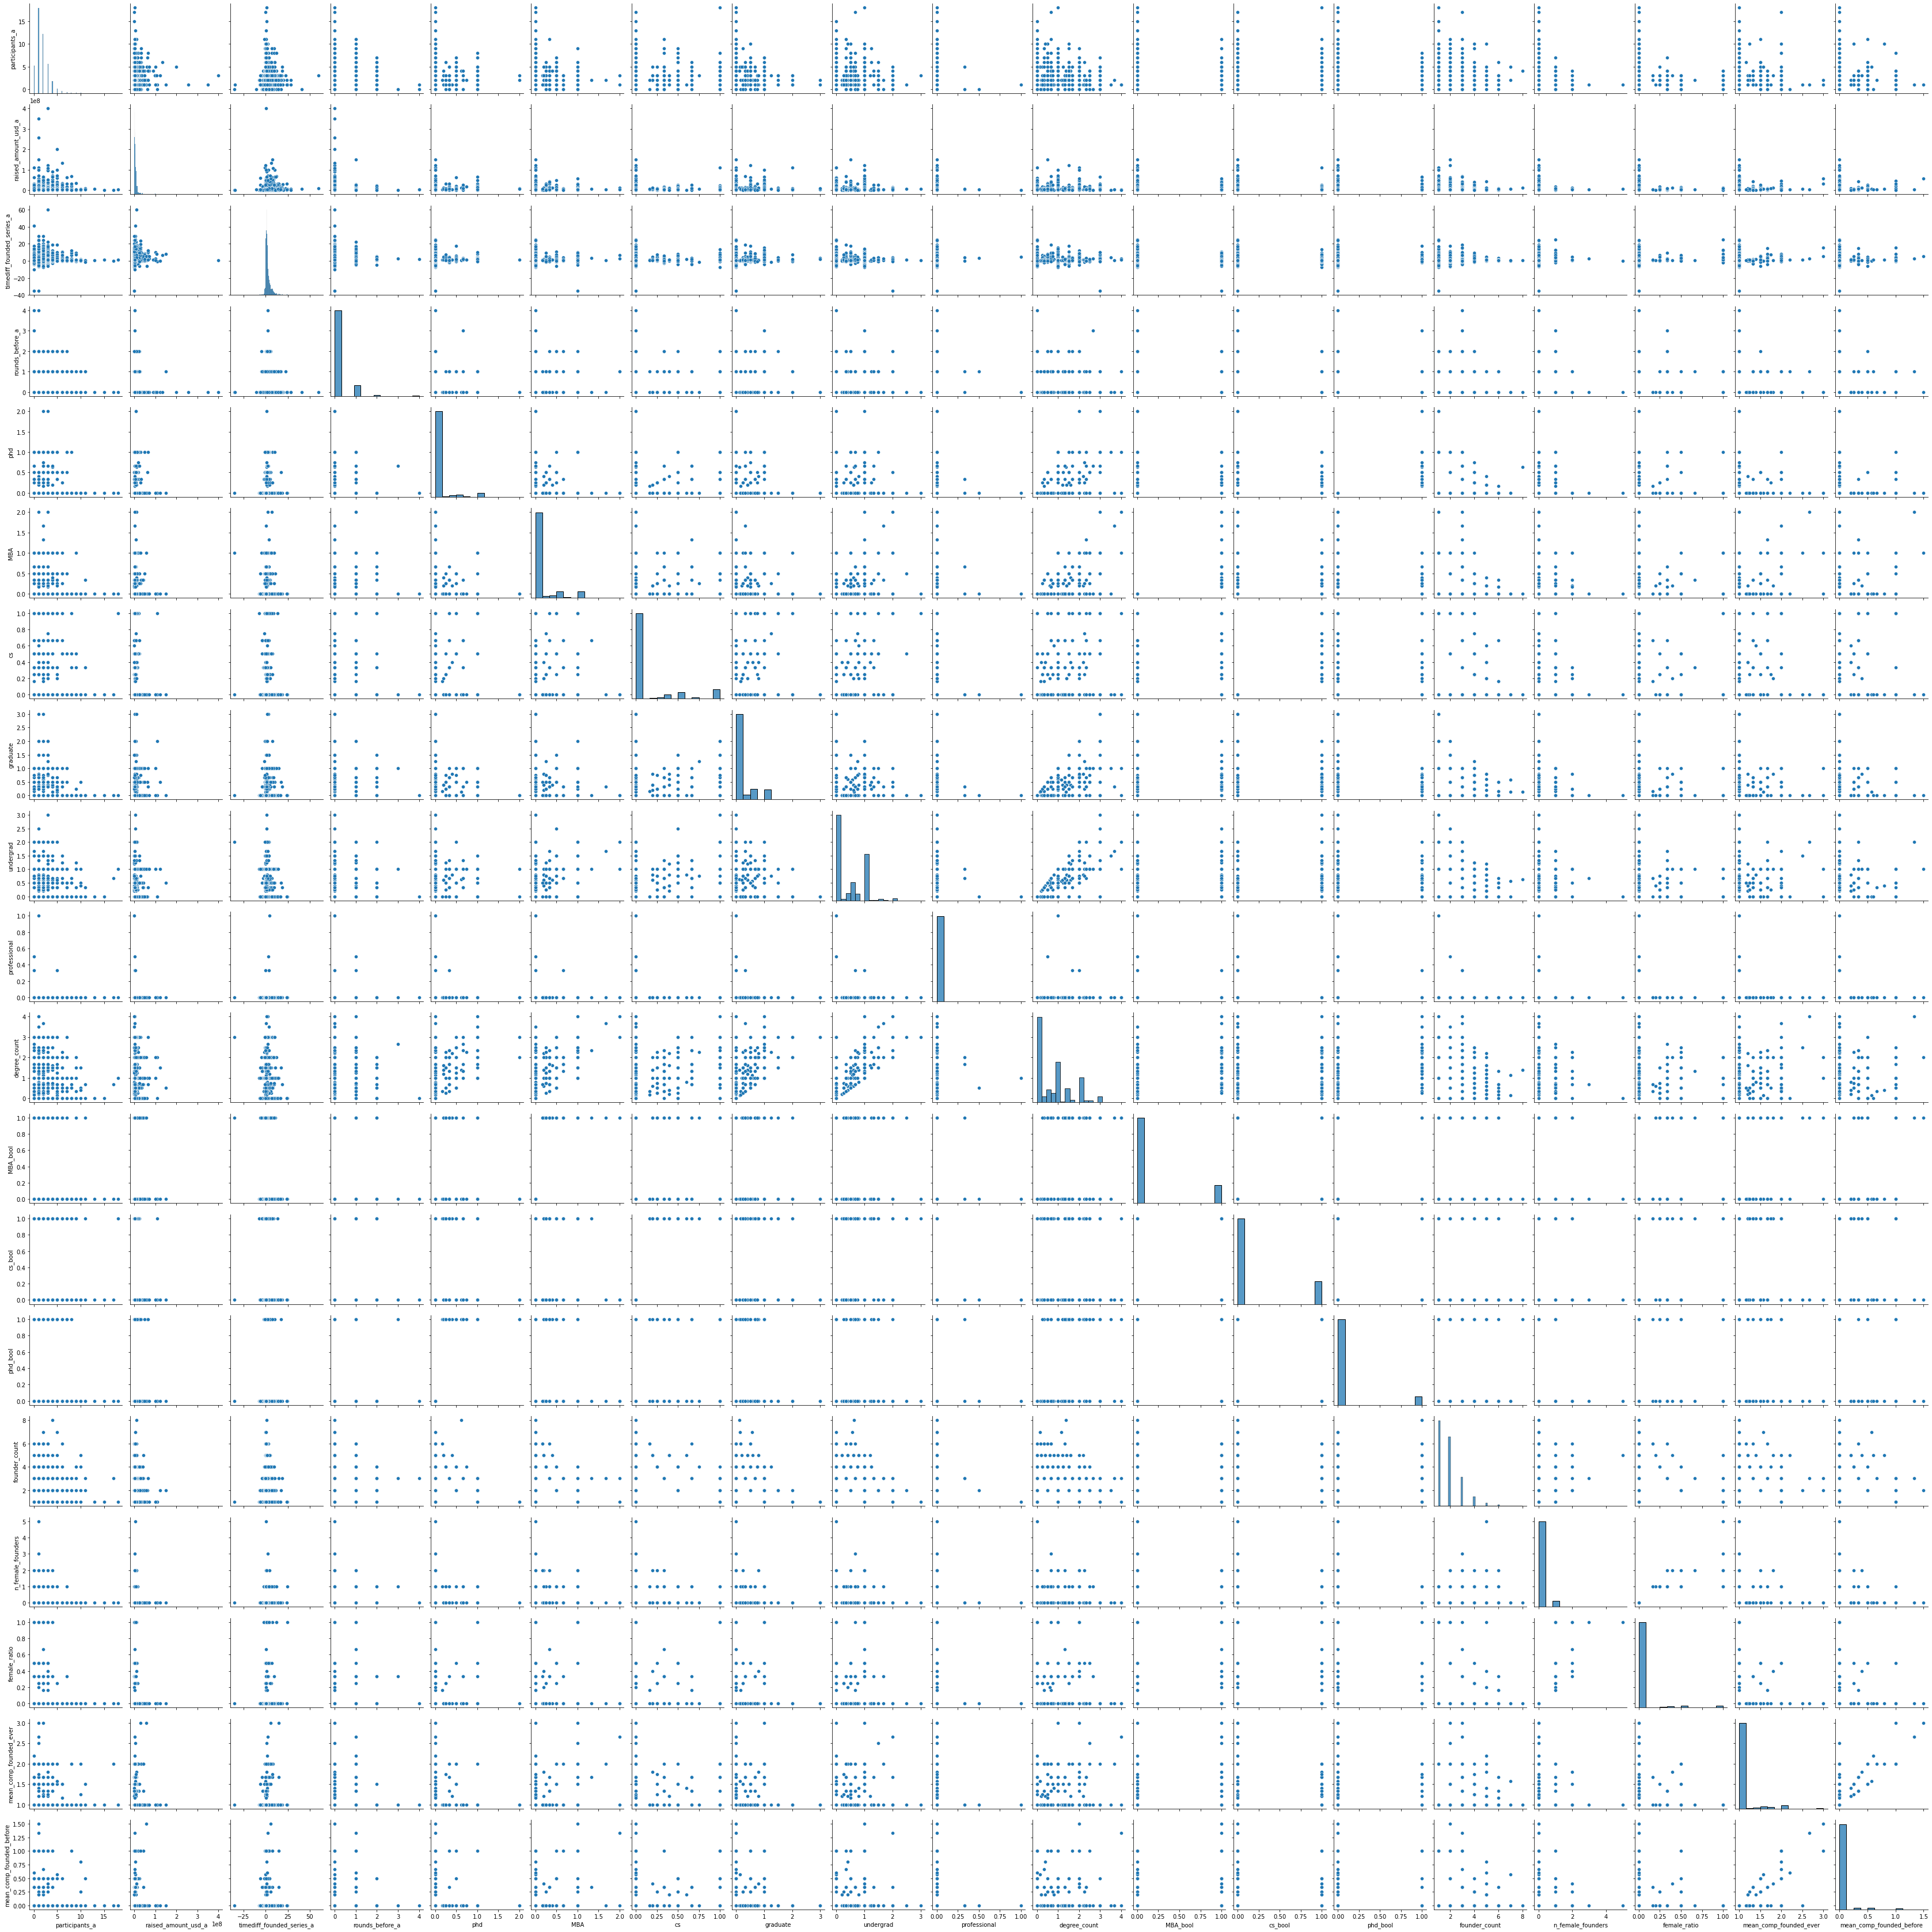

In [69]:
sns.pairplot(companies_a)

<AxesSubplot:>

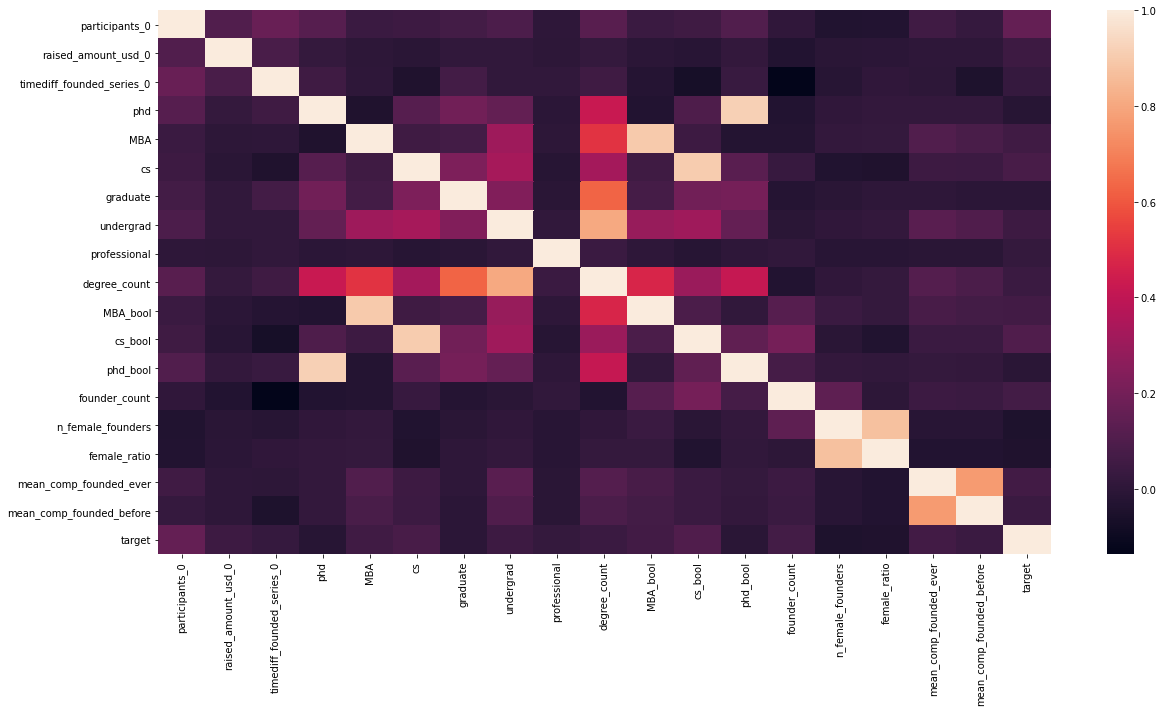

In [42]:
import matplotlib.pyplot as plt
Fig , axs = plt.subplots(1,1, figsize = (20,10))

sns.heatmap(companies.corr(), ax = axs)

# Preprocessing Data

### Cleaning Data

#### Droping the observations with more than X number of nan values

In [299]:
def clean_data(reference):
    
    ''' quit nan observations with more than X nan values 
        quit outliers'''
    companies= get_training_data(reference)
    
    #Drop not important columns
    companies = companies.drop(columns= ['normalized_name','founded_at', 'description' ,'exit', 'exit_date', f'date_series_{reference}', 'closed_at']).set_index('id')
    
    #quit observation with more than 5 nan
    companies = companies[companies.isnull().sum(axis=1) < 5]
    
    #quiting outliers 
    companies = companies[companies[f'raised_amount_usd_{reference}']<=450000000]
    
    #Standarizing STATES 
    #henri df
    df = pd.read_csv('..\\raw_data\\datanamed_completed.csv', sep=';', header=1) #Warning: Modify the path!!!!
    df = df[df.country_code=='USA'][['id', 'state_code']]
    
    merge_1 = companies.merge(df, how ='left', on = 'id')
    dict2 = merge_1.state_code_x.reset_index(drop=True).to_dict()
    dict1 = merge_1.state_code_y.reset_index(drop=True).to_dict()
    for i in dict1:
        if type(merge_1.state_code_y.reset_index(drop=True).to_dict()[i]) == type(""):
            dict2[i] = dict1[i]
        else:
            dict2[i] = 'other'
    merge_1['state_code'] = dict2.values()
    merge_1 = merge_1.drop(columns = ['state_code_y', 'state_code_x'])
    
    #Completing Countries columns
    
    df = pd.read_csv('..\\raw_data\\countries_filled.csv', sep=';')[['id','country_code', 'state_code']] #Warning: Modify the path!!!!
    
    
    merge_2 = merge_1.merge(df, how ='left', on = 'id')
    
    dict1 = merge_2.state_code_y.reset_index(drop=True).to_dict()
    dict2 = merge_2.state_code_x.reset_index(drop=True).to_dict()
    dict3 = merge_2.country_code_y.reset_index(drop=True).to_dict()
    dict4 = merge_2.country_code_x.reset_index(drop=True).to_dict()
    
    for i in dict1:
        if type(merge_2.state_code_y.reset_index(drop=True).to_dict()[i]) == type(""):
            dict2[i] = dict1[i]
        else:
            dict2[i] = 'other'
            
    for i in dict3:
        if type(merge_2.country_code_y.reset_index(drop=True).to_dict()[i]) == type(""):
            dict4[i] = dict3[i]    
            
    merge_2['state_code'] = dict2.values()
    merge_2['country_code'] = dict4.values()
    merge_2 = merge_2.drop(columns = ['state_code_y', 'state_code_x', 'country_code_y', 'country_code_x'])
    
    
    # Completing the categories
    
    df = pd.read_csv('..\\raw_data\\categories_filled.csv', sep=';')[['id', 'category_code']]
    
    merge_3 = merge_2.merge(df, how ='left', on = 'id')
    
    dict1 = merge_3.category_code_y.reset_index(drop=True).to_dict()
    dict2 = merge_3.category_code_x.reset_index(drop=True).to_dict()
    
    for i in dict1:
        if type(merge_3.category_code_y.reset_index(drop=True).to_dict()[i]) == type(""):
            dict2[i] = dict1[i]
            
    merge_3['category_code'] = dict2.values()
    merge_3 = merge_3.drop(columns = ['category_code_x', 'category_code_y'])
    
    return merge_3.set_index('id')

In [300]:
companies = clean_data('a')

In [302]:
companies.columns

Index(['participants_a', 'raised_amount_usd_a', 'timediff_founded_series_a',
       'rounds_before_a', 'raised_before_a', 'participants_before_a', 'phd',
       'MBA', 'cs', 'graduate', 'undergrad', 'professional', 'degree_count',
       'MBA_bool', 'cs_bool', 'phd_bool', 'founder_count', 'top_5', 'top_20',
       'top_50', 'top_5_bool', 'top_20_bool', 'top_50_bool',
       'n_female_founders', 'female_ratio', 'mean_comp_founded_ever',
       'mean_comp_founded_before', 'target', 'state_code', 'country_code',
       'category_code'],
      dtype='object')

#### Outliers and distributions

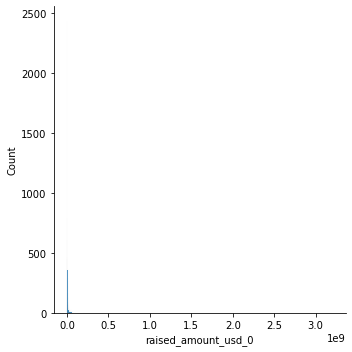

In [268]:
#plt.figure(figsize = (15,10))
#pd.DataFrame(companies_0.raised_amount_usd_0).boxplot()
sns.displot(data = companies_0, x="raised_amount_usd_0")

### Features and Target

In [38]:
X = companies.drop(columns='target')
y =companies['target']

### Making Pipeline

In [289]:
# Step to be sure about the order 
columnas = ['participants_a','participants_before_a','raised_amount_usd_a', 'raised_before_a', 'rounds_before_a', 'timediff_founded_series_a', 'phd', 'MBA', 'cs',
                                                    'graduate', 'undergrad', 'professional', 'degree_count',
                                                    'founder_count', 'n_female_founders','female_ratio', 
                                                    'mean_comp_founded_ever', 'mean_comp_founded_before', \
                                                    'top_5', 'top_20','top_50','MBA_bool', 'cs_bool', 'phd_bool' ,'top_5_bool', 'top_20_bool', \
                                                    'top_50_bool','state_code', 'country_code', 'category_code','target' ]
companies = companies[columnas]

X = companies.drop(columns=['target'])
y =companies['target']

In [274]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Columns by feature categories
categorical_features = list(companies.select_dtypes('object').columns)
numerical_features = columnas[0:-4]

professional_features = ['phd', 'MBA', 'cs','graduate', 'undergrad', 
                                                   'professional', 'degree_count','founder_count', 
                                                   'n_female_founders','female_ratio', 'mean_comp_founded_ever', 
                                                   'mean_comp_founded_before']
top_features_num = ['top_5', 'top_20','top_50']


boolean_features = ['MBA_bool', 'cs_bool', 'phd_bool' ,'top_5_bool', 'top_20_bool', 'top_50_bool']

investment_amount_features = ['raised_amount_usd_a', 'raised_before_a', 'rounds_before_a' ]

time_feature = ['timediff_founded_series_a']

participant_feature = ['participants_a', 'participants_before_a']



#scalers and imputers
degrees_imputer = SimpleImputer()
notdegrees_imputer = KNNImputer() 

raised_amount_scaler = RobustScaler()
profesionals_scaler = MinMaxScaler()

timediff_scaler = StandardScaler()
participant_scaler = StandardScaler()

#pipes for each feature

pipe_amounts = Pipeline([('raised_amount_imputer', notdegrees_imputer),
                         ('raised_amount_scaler', raised_amount_scaler)]) 



pipe_categorical = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])


pipe_professionals = Pipeline([('profesionals_scaler', profesionals_scaler)])

pipe_time = Pipeline([('time_imput', notdegrees_imputer),
                      ( 'timediff_scaler', timediff_scaler )
                     ])

pipe_participants =  Pipeline([('participant_imputer', notdegrees_imputer ),
                              ('participant_scaler', participant_scaler)])


#process

feateng_blocks = [ ('participant_scaler', pipe_participants, participant_feature),
                   ('investment_scaler', pipe_amounts, investment_amount_features),# cambiar en caso de 0
                   ('timediff_scaler', pipe_time, time_feature),
                   ('profesionals_scaler', pipe_professionals, professional_features),
                   ('top_scale', MinMaxScaler(), top_features_num), #just to stablish order of output columns
                   ('bolean_var',  MinMaxScaler(), boolean_features), #just to stablish order of output columns
                   ('cat_pipe', pipe_categorical, categorical_features)]



#Columntransformer keeping order
preprocessor = ColumnTransformer(feateng_blocks)

pipeline = Pipeline([
                    ('preprocessing', preprocessor), 
                    ('rgs', LogisticRegression())
])


In [261]:
pipeline.fit(X)
cat_columns = preprocessor.named_transformers_['cat_pipe']['ohe'].get_feature_names(categorical_features)
columns = np.append(numerical_features, cat_columns)

#pd.DataFrame(pipeline.fit_transform(X).todense(), columns = columns)

## Spliting train and test

In [212]:
companies = clean_data('a')

In [262]:
X = companies.drop(columns = 'target')
y = companies['target']


In [263]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [101]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_a_train, y_a_train)

model.score(X_a_test,y_a_test)


c:\users\felipe\.venvs\lewagon\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6818181818181818

In [ ]:
import mlflow
from  mlflow.tracking import MlflowClient
mlflow.set_tracking_uri("https://mlflow.lewagon.co/")
EXPERIMENT_NAME = "Invesscience batch #463"

client = MlflowClient()
experiment_id = client.create_experiment(EXPERIMENT_NAME)

for model in ["linear", "Randomforest"]:
    run = client.create_run(experiment_id)
    client.log_metric(run.info.run_id, "rmse", 4.5)
    client.log_param(run.info.run_id, "model", model)



In [127]:
def compute_precision(y_pred, y_true):

    predicted = 0
    actually = 0
    
    for(idx, y_p) in enumerate(y_pred):
        if y_p ==1:
            predicted +=1
            if y_true[idx]==1:
                actually +=1
    if predicted ==0:
        return 0
    else:
        return actually/predicted

def compute_recall(y_pred, y_true):

    predicted = 0
    actually = 0
    FN= 0
    for(idx, y_p) in enumerate(y_pred):
        
        if y_true[idx]==1:
            actually +=1
        if y_p ==0:
            if y_true[idx] ==1:
                FN +=1
                
    if (2*actually - predicted) ==0:
        return 0
    else:
        return abs(actually/(actually + FN))


def compute_f1(y_pred, y_true):

    recall = compute_recall(y_pred, y_true)
    precision = compute_precision(y_pred, y_true)

    return (2*precision*recall)/(precision+recall)



In [144]:

_true = [0,1,0,1,1,0]
_pred = [1,0,1,1,1,1]

display(compute_recall(_true, _pred))
display(compute_precision(_true, _pred))

0.625

0.6666666666666666

In [145]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

recall = recall_score(_true, _pred)
precision = precision_score(_true,_pred)


recall, precision

(0.6666666666666666, 0.4)

In [146]:
get_training_data(reference='a')

,id,normalized_name,category_code,founded_at,description,closed_at,exit,exit_date,country_code,state_code,date_series_a,participants_a,raised_amount_usd_a,timediff_founded_series_a,rounds_before_a,phd,MBA,cs,graduate,undergrad,professional,degree_count,MBA_bool,cs_bool,phd_bool,founder_count,n_female_founders,female_ratio,mean_comp_founded_ever,mean_comp_founded_before,target
0,c:1349,move networks,software,NaT,software Move Networks is a streaming tech pla...,NaN,acquisition,1987-06-16 00:00:00,USA,CA,2006-12-01,2,11300000.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,c:4584,modern feed,games_video,2007-01-01,games_video [Modern Feed](http://www.moder...,NaN,acquisition,1987-06-16 00:00:00,USA,CA,2007-04-01,0,3000000.0,0.246412,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,1
2,c:16612,micron technology,semiconductor,1978-01-01,semiconductor Semiconductor Applications Mic...,NaN,ipo,1990-01-02 00:00:00,USA,ID,2006-10-25,1,6410400.0,28.813733,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,c:28,cisco,network_hosting,1984-01-01,network_hosting Cisco designs and sells ha...,NaN,ipo,1990-02-23 00:00:00,USA,CA,1987-01-01,1,2500000.0,3.000746,0.0,0.000000,0.0,0.000000,1.000000,1.000000,0.0,2.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,1
4,c:29,yahoo,web,1994-01-01,web News and On-line directory Yahoo was fou...,NaN,ipo,1996-04-12 00:00:00,USA,CA,1995-04-01,1,2000000.0,1.245748,0.0,0.400000,0.2,0.400000,0.800000,0.800000,0.0,2.200000,1.0,1.0,1.0,5.0,0.0,0.0,1.200000,0.0,1
5,c:317,amazon,ecommerce,1994-01-01,"ecommerce Amazon.com, Inc. (AMZN), is a le...",NaN,ipo,1997-05-01 00:00:00,USA,WA,1995-07-01,1,8000000.0,1.494897,0.0,0.000000,0.5,0.000000,0.500000,0.500000,0.0,1.500000,1.0,0.0,0.0,2.0,0.0,0.0,1.000000,0.0,1
6,c:11700,geocities,network_hosting,1996-01-01,network_hosting Yahoo! Personal Web Hosting ...,2009-10-26,acquisition,1999-01-28 00:00:00,NaN,NaN,1995-01-01,1,2000000.0,-0.999336,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,1
7,c:26738,lightera,public_relations,1998-02-01,public_relations Bandwidth-management equipm...,NaN,acquisition,1999-03-01 00:00:00,USA,CA,1998-03-24,0,0.0,0.139633,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,c:1611,match,web,1995-04-01,web Match.com pioneered online dating when...,NaN,acquisition,1999-06-01 00:00:00,USA,TX,1960-01-01,0,0.0,-35.247815,0.0,0.000000,1.0,0.000000,0.000000,2.000000,0.0,3.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,1
9,c:2720,xo group,web,1996-01-01,web The XO Group is a lifestage media and tech...,NaN,ipo,1999-12-02 00:00:00,USA,NY,1996-01-01,1,1600000.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,2.0,1.0,0.5,1.000000,0.0,1
